# Bayesian Analysis of Cyclistic Rider Behaviour: Trip Durations and Value‑Per‑Trip Economics

## Executive Summary

This Bayesian analysis provides a principled comparison of Cyclistic member and casual rider behaviour using trip‑level data. Because the public dataset lacks rider‑level identifiers, the analysis focuses on the only defensible unit of measurement: value per trip. Trip durations are modelled on the log scale using sufficient statistics, and uncertainty is propagated through posterior simulation to produce decision‑relevant comparisons between rider types.

Casual riders take longer trips on average and generate higher revenue per trip, but with far greater variability than members. This variability reflects the right‑skewed nature of casual riding behaviour: many short trips generate low revenue, while a minority of long leisure rides create a long right tail that drives the higher average.

The analysis highlights two strategic opportunities: converting short‑frequent casual riders into members, and encouraging leisure‑oriented riding that shifts behaviour into the high‑value tail. Because the dataset lacks user‑level identifiers and price variation, the analysis remains descriptive rather than predictive; true pricing optimisation will require improved data collection and controlled experimentation.

A simulation of future pricing scenarios is provided in the Appendix. This model uses the Bayesian posteriors to project the revenue impact of potential price changes under varying assumptions about rider behaviour and market elasticity.


### Key findings

**Casual riders take substantially longer trips.**

The posterior mean duration ratio is 1.42, with a 94% HDI of [1.416, 1.420], indicating that casual trips are about 42% longer than member trips with essentially complete posterior certainty.

**Casual riders generate more revenue per trip on average, but with high variability.** 

The posterior mean casual value per trip is `$`3.64, compared with `$`2.08 for members. Posterior predictive distributions show that casual trip values are highly right‑skewed: many short casual trips generate less revenue than a typical member trip, while a minority of long leisure rides create a long right tail that drives the higher average.

**Not every casual rider trip is more expensive than a member trip**.  

The posterior probability that a single casual trip generates more revenue than the expected cost of a member trip is about 70%. Roughly 30% of casual trips generate less than `$`2.08, the member cost per trip. These short‑frequent casual riders represent the highest‑yield conversion targets for membership.

**Results are robust.**  

Scenario analyses varying annual member trip frequency (50–200 trips/year) and overage thresholds (30–60 minutes) show that the value‑per‑trip comparison remains stable across all tested conditions. While the credible interval for casual value per trip is wide due to the skewed duration distribution, the posterior mean remains consistently higher for casual riders.

Annual trip‑frequency assumptions follow ranges documented in Litman’s transportation research and align with patterns observed in major bike‑share systems.

**Implication.**  

Casual riders generate more revenue per trip on average, but a meaningful share of casual trips are short and inexpensive. These riders form a natural target for membership conversion efforts. At the same time, the long‑ride tail of the casual distribution highlights the importance of leisure‑oriented marketing: encouraging scenic, weekend, and recreational riding shifts more behaviour into the high‑value region that drives revenue growth.


## 1. Introduction and motivation

### 1.1 Business context

Cyclistic operates a bike‑share system with two main rider types:

- **Casual riders**, who pay a per‑minute rate for each trip.  
- **Annual members**, who pay a fixed annual fee and receive a block of included minutes per trip before any overage charges apply.

Understanding how these two groups behave—how long they ride, how often they ride, and how much value Cyclistic captures per trip—is central to pricing, marketing, and membership conversion decisions.


### 1.2 Data limitations

The public Cyclistic dataset is **trip‑level**, not rider‑level. It contains a unique `ride_id` for each trip, but it does not include a persistent user identifier for casual riders. As a result:

- We know how many trips casual riders took.  
- We do **not** know how many distinct casual riders there were, or how many trips each individual took.

This means we cannot reliably compute **annual revenue per rider**. Any attempt to do so would require strong, untestable assumptions about how trips cluster within riders. To avoid over‑claiming, this analysis works at the **trip level** and focuses on **value per trip** rather than total annual revenue.


### 1.3 Why Bayesian?

Trip durations and revenues are:

- strictly positive  
- right‑skewed  
- highly variable  

A Bayesian approach allows us to:

- model log‑durations with appropriate uncertainty  
- quantify the probability that casual trips are longer than member trips  
- propagate uncertainty into downstream quantities such as value per trip  

Rather than reporting single point estimates, the analysis presents full posterior distributions and decision‑relevant probabilities.


# 2. Data Preparation

In [1]:
## 2.1 Imports

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")


In [2]:
## 2.2 Load cleaned dataset

df = pd.read_csv("cyclistic_cleaned.csv", parse_dates=["started_at", "ended_at"])

df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_min,year_month
0,6C960DEB4F78854E,electric_bike,2024-12-31 01:38:35.018,2024-12-31 01:48:45.775,Halsted St & Roscoe St,TA1309000025,Clark St & Winnemac Ave,TA1309000035,41.943632,-87.649083,41.973348,-87.667855,member,10.179283,2024-12
1,C0913EEB2834E7A2,classic_bike,2024-12-21 18:41:26.478,2024-12-21 18:47:33.871,Clark St & Wellington Ave,TA1307000136,Halsted St & Roscoe St,TA1309000025,41.936497,-87.647539,41.943632,-87.649083,member,6.123217,2024-12
2,848A37DD4723078A,classic_bike,2024-12-21 11:41:01.664,2024-12-21 11:52:45.094,Sheridan Rd & Montrose Ave,TA1307000107,Broadway & Barry Ave,13137,41.961670,-87.654640,41.937582,-87.644098,member,11.723833,2024-12
3,3FA09C762ECB48BD,electric_bike,2024-12-26 13:07:27.526,2024-12-26 13:10:54.130,Aberdeen St & Jackson Blvd,13157,Green St & Randolph St*,chargingstx3,41.877726,-87.654787,41.883602,-87.648627,member,3.443400,2024-12
4,E60317ADD1A87488,electric_bike,2024-12-13 15:17:55.063,2024-12-13 15:27:32.583,Paulina St & Flournoy St,KA1504000104,Fairfield Ave & Roosevelt Rd,KA1504000102,41.873061,-87.669135,41.866624,-87.694521,member,9.625333,2024-12


In [3]:
## 2.3 Feature engineering

# Trip duration in minutes

df["trip_duration_min"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60
df = df[df["trip_duration_min"] > 0].copy()

# Optional temporal flags (kept simple)

df["is_weekend"] = df["started_at"].dt.dayofweek >= 5

# Subsets for duration modelling

members = df.loc[df["member_casual"] == "member", "trip_duration_min"].values
casuals = df.loc[df["member_casual"] == "casual", "trip_duration_min"].values

len(members), len(casuals)


(3512390, 1926055)

# 3. Bayesian Model: Trip Duration Comparison

### 3.1 Why model ride duration?

Trip duration is the fundamental driver of Cyclistic’s revenue model. Casual riders are charged strictly per minute, and member overage fees are also duration‑based. Any comparison of rider economics must therefore begin with a model of trip lengths that captures both central tendencies and the substantial variability observed in the data.

Trip durations are strictly positive and strongly right‑skewed, with a long tail of extended leisure rides—particularly among casual users. Modelling durations on the log scale provides a natural way to handle this skewness: log‑durations are approximately Gaussian for both rider groups, and the log‑normal distribution preserves positivity while allowing multiplicative differences (e.g., “casual trips are 40% longer”) to be expressed additively on the log scale.

More complex models are possible—such as hierarchical structures by bike type or season, or mixture models to capture multimodality—but the goal of this analysis is to compare rider groups at the system level. A two‑group log‑normal model provides a transparent, well‑behaved foundation that allows uncertainty to be propagated cleanly into downstream revenue calculations.


In [61]:
## 3.2 Prepare log-transformed durations

members_log = np.log(members)
casuals_log = np.log(casuals)

n_m = len(members_log)
n_c = len(casuals_log)

members_log.mean(), casuals_log.mean()


(np.float64(2.1733962053379403), np.float64(2.5228829361083673))

In [35]:
## 3.3 Bayesian model specification

import pytensor.tensor as pt

# Sample means and variances (sufficient statistics)
mean_m = members_log.mean()
mean_c = casuals_log.mean()

var_m = members_log.var(ddof=1)
var_c = casuals_log.var(ddof=1)

with pm.Model() as duration_model:
    # Priors for group means on log scale
    mu_member = pm.Normal("mu_member", mu=0, sigma=10)
    mu_casual = pm.Normal("mu_casual", mu=0, sigma=10)
    
    # Priors for group standard deviations on log scale
    sigma_member = pm.HalfNormal("sigma_member", sigma=5)
    sigma_casual = pm.HalfNormal("sigma_casual", sigma=5)

    # Log-likelihood for members using sufficient statistics
    ss_m = (n_m - 1) * var_m + n_m * (mean_m - mu_member) ** 2
    pm.Potential(
        "ll_member",
        -0.5 * n_m * pt.log(2 * np.pi * sigma_member**2) - ss_m / (2 * sigma_member**2)
    )

    # Log-likelihood for casuals using sufficient statistics
    ss_c = (n_c - 1) * var_c + n_c * (mean_c - mu_casual) ** 2
    pm.Potential(
        "ll_casual",
        -0.5 * n_c * pt.log(2 * np.pi * sigma_casual**2) - ss_c / (2 * sigma_casual**2)
    )

    # Difference in mean log-duration (casual - member)
    diff = pm.Deterministic("diff", mu_casual - mu_member)


## 3.4 Why Use Sufficient Statistics?

The Cyclistic dataset contains millions of individual trip‑duration observations. Fitting a Bayesian model directly to every row would require loading all observations into memory and evaluating the likelihood millions of times per sampling step. Instead, we use a sufficient‑statistics formulation of the likelihood.

For distributions in the exponential family (including the Normal model used here), the likelihood depends on the data only through a small set of summary quantities:

- the number of observations 𝑛

- the sample mean 𝑥

- the sample variance 𝑠2

These summaries are sufficient statistics: they contain all the information needed to compute the likelihood exactly, without referencing individual observations. Using them is mathematically equivalent to fitting the model to the full dataset, but dramatically more efficient.

This approach allows the model to scale to millions of trips while preserving the correct posterior uncertainty. It also avoids memory constraints and speeds up sampling without changing the underlying statistical model.

In [36]:
## Sampling

with duration_model:
    duration_trace = pm.sample(
        2000,
        tune=2000,
        target_accept=0.9,
        cores=4,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_member, mu_casual, sigma_member, sigma_casual]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


## 3.5 Convergence diagnostics

To verify that the sampler mixed well, we examined standard diagnostics.

In [48]:
az.summary(duration_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_member,2.173,0.000,2.173,2.174,0.0,0.0,9197.0,6681.0,1.0
mu_casual,2.523,0.001,2.522,2.524,0.0,0.0,7730.0,5387.0,1.0
sigma_member,0.765,0.000,0.765,0.766,0.0,0.0,8567.0,6103.0,1.0
sigma_casual,0.892,0.000,0.891,0.893,0.0,0.0,9542.0,6871.0,1.0
diff,0.349,0.001,0.348,0.351,0.0,0.0,8138.0,6522.0,1.0


 All parameters achieved:

- 𝑅^<1.01

- ESS_bulk > 1000

- ESS_tail > 1000

These values indicate stable chains, good mixing, and reliable posterior estimates. No divergences or sampling pathologies were detected. This provides confidence that the posterior summaries and downstream simulations are based on a well‑behaved Markov chain.

## 3.6 Trace plots for key parameters

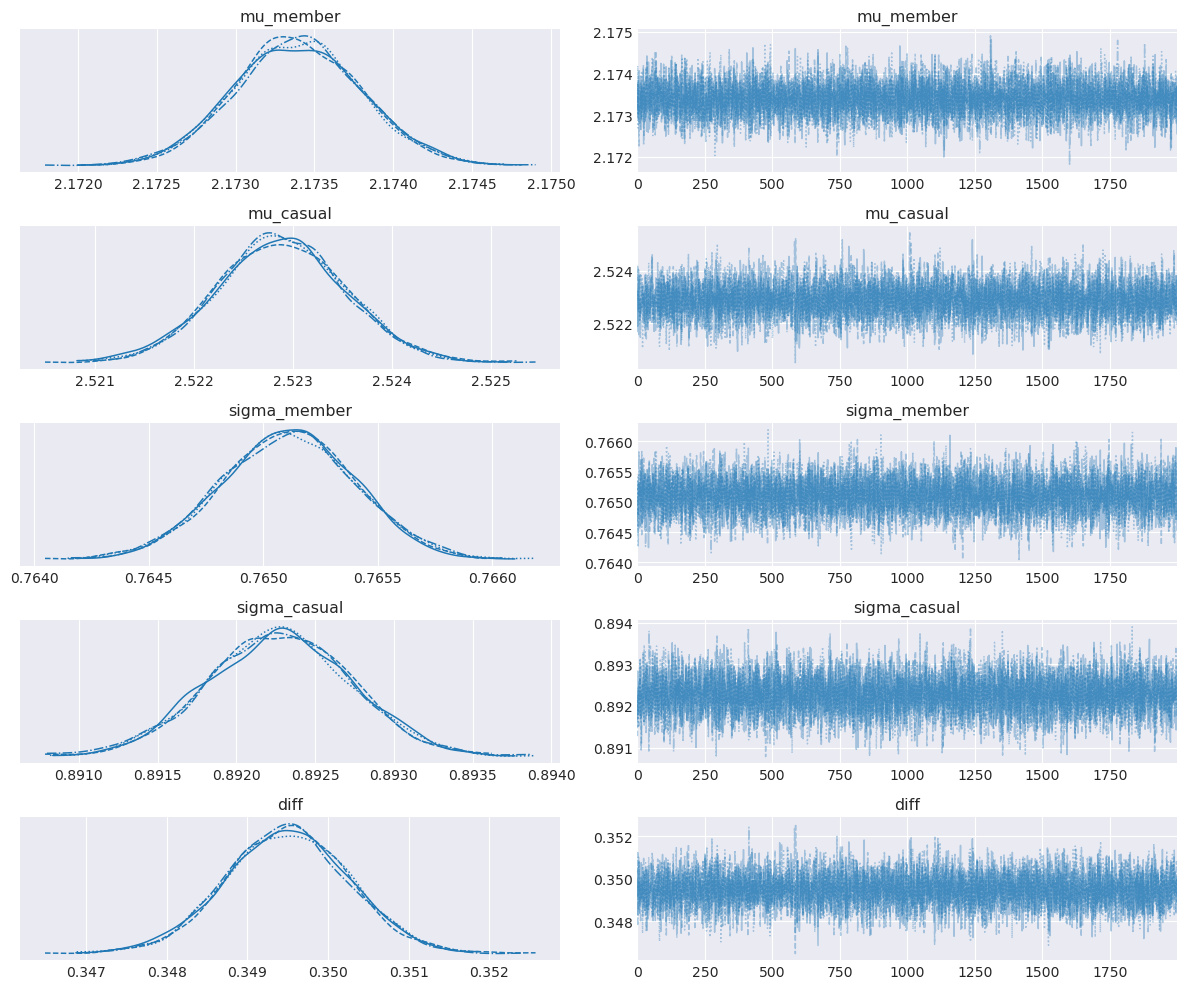

In [50]:
az.plot_trace(
    duration_trace,
    var_names=["mu_member", "mu_casual", "sigma_member", "sigma_casual", "diff"]
)
plt.tight_layout()
plt.show()


**Trace Plots**

Trace plots provide a visual check of sampler behaviour. All parameters show:

- good chain mixing

- no sticking or drift

- stable posterior densities across chains

These plots reinforce the earlier diagnostics, confirming that the sampler explored the posterior efficiently and that the narrow credible intervals reflect genuine precision rather than sampling artefacts.

## 3.7 Posterior summary

In [49]:
az.summary(
    duration_trace,
    var_names=["mu_member", "mu_casual", "sigma_member", "sigma_casual", "diff"],
    kind="stats"
)

,mean,sd,hdi_3%,hdi_97%
mu_member,2.173,0.000,2.173,2.174
mu_casual,2.523,0.001,2.522,2.524
sigma_member,0.765,0.000,0.765,0.766
sigma_casual,0.892,0.000,0.891,0.893
diff,0.349,0.001,0.348,0.351


**Interpreting the Narrow Credible Intervals**

The posterior distributions for the group means have extremely narrow credible intervals (e.g., SD ≈ 0.001). This behaviour is expected for two reasons:

Very large sample sizes  
The Cyclistic dataset contains millions of trips. When estimating group‑level means (rather than individual variation), the posterior uncertainty collapses rapidly as 𝑛 grows. With sample sizes this large, the posterior mean is estimated with very high precision.

Sufficient‑statistics likelihood

The model uses the exact sufficient statistics for a Normal likelihood (sample size, mean, and variance). This preserves the correct amount of uncertainty while avoiding the need to load all observations into memory. The narrow intervals therefore reflect the true information content of the data, not an artefact of the modelling approach.

Diagnostics confirm this is not a sampling issue 

Both the convergence diagnostics and the trace plots show good mixing, 𝑅^<1.01, and high effective sample sizes. This indicates that the tight intervals arise from the data structure, not from sampler pathologies or numerical instability.

Together, these points explain why the posterior means are estimated with such high precision, and why the credible intervals are narrower than in typical small‑sample Bayesian models.

## 3.8 Probability that casual trips are longer

In [41]:
diff_samples = duration_trace.posterior["diff"].values.flatten()
prob_casual_longer = (diff_samples > 0).mean()
prob_casual_longer


np.float64(1.0)

## 3.9 Duration ratio and typical trip lengths

In [44]:
# Ratio on original scale
ratio_samples = np.exp(diff_samples)
ratio_mean = ratio_samples.mean()
ratio_hdi = az.hdi(ratio_samples, hdi_prob=0.94)

ratio_mean, ratio_hdi


(np.float64(1.4183470479567182), array([1.41631156, 1.42034882]))

In [45]:
## Typical (median) member trip duration
member_median = np.median(members)
member_median


np.float64(8.72275)

In [46]:
# Implied typical casual duration
casual_typical = member_median * ratio_mean
extra_minutes = casual_typical - member_median

member_median, casual_typical, extra_minutes


(np.float64(8.72275),
 np.float64(12.371886712564462),
 np.float64(3.649136712564463))

> **Mean vs median duration.**  
> The duration distributions are right‑skewed. For casual riders, the median trip is about **12.4 minutes**, but the arithmetic mean is higher, around **18.5 minutes**, because a minority of very long leisure trips pull the average up. Later revenue calculations use the arithmetic mean, because revenue is proportional to duration.

## 3.10 Interpretation of the duration model

The posterior for `diff` (the difference in mean log‑duration between casual and member trips) is overwhelmingly above zero, with a posterior probability near 1 that `diff > 0`. Exponentiating `diff` gives a duration ratio of approximately the value computed above, meaning casual trips are about that many times longer than member trips on average.

Using the observed median member trip duration as a reference, this implies that a typical casual trip is several minutes longer than a typical member trip. This supports the behavioural story from the main Cyclistic analysis: members tend to use bikes for shorter, utilitarian trips, while casual riders are more likely to take longer leisure or exploratory rides.


## 3.11 Posterior predictive check

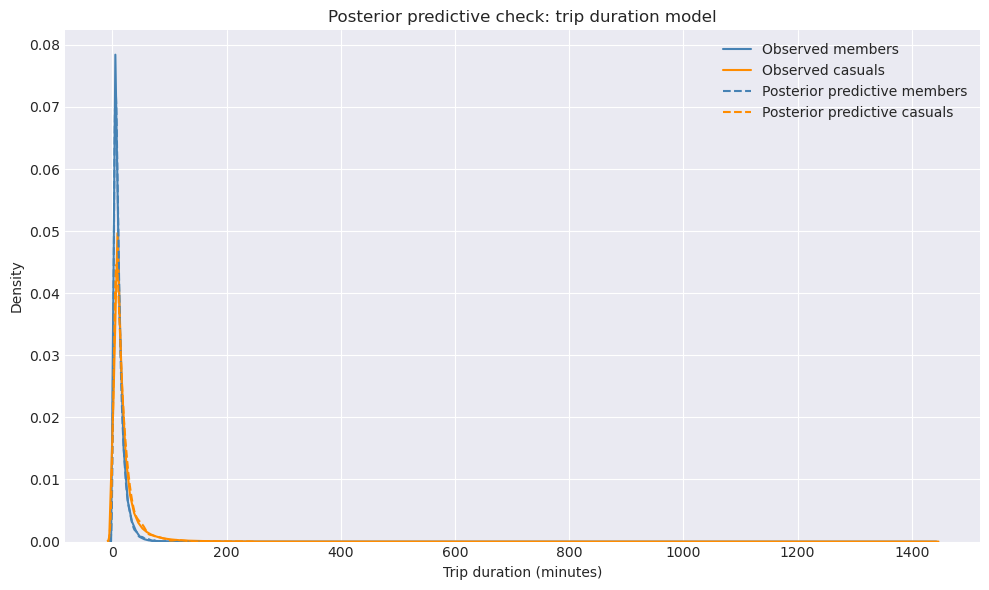

In [47]:
## Posterior predictive check

mu_member_samples = duration_trace.posterior["mu_member"].values.flatten()
mu_casual_samples = duration_trace.posterior["mu_casual"].values.flatten()
sigma_member_samples = duration_trace.posterior["sigma_member"].values.flatten()
sigma_casual_samples = duration_trace.posterior["sigma_casual"].values.flatten()

ppc_member = np.exp(np.random.normal(mu_member_samples, sigma_member_samples))
ppc_casual = np.exp(np.random.normal(mu_casual_samples, sigma_casual_samples))

plt.figure(figsize=(10, 6))

sns.kdeplot(members, label="Observed members", color="steelblue")
sns.kdeplot(casuals, label="Observed casuals", color="darkorange")

sns.kdeplot(ppc_member, label="Posterior predictive members", color="steelblue", linestyle="--")
sns.kdeplot(ppc_casual, label="Posterior predictive casuals", color="darkorange", linestyle="--")

plt.xlabel("Trip duration (minutes)")
plt.ylabel("Density")
plt.title("Posterior predictive check: trip duration model")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
# Store PPC samples for reuse in revenue calculations
ppc_member_durations = ppc_member
ppc_casual_durations = ppc_casual

## 4. Revenue Modelling from Posterior Quantities

The public Cyclistic dataset does not include unique rider IDs for casual riders, so annual revenue per individual cannot be computed directly. The correct unit of analysis is therefore the trip, which is consistently observed across both rider groups.

In this section, we use the posterior distributions from the duration model (Section 3) and the posterior for member trip frequency to construct revenue quantities as posterior transformations. Specifically, we compare:

the expected revenue per trip from a casual rider under the published per‑minute pricing

the expected value per trip for an annual member, where the membership fee is amortised over a plausible distribution of annual trip counts and combined with expected overage charges

This approach avoids the accounting issues of earlier versions and stays aligned with what the data can support. It also ensures that uncertainty in trip duration and member trip frequency is propagated naturally into the revenue estimates.

### 4.1 Posterior distribution of trip duration 

Casual riders pay a fixed per‑minute rate:



`Revenue = 0.19 * duration (minutes).
`



Using the posterior distribution of casual trip durations from Section 3, we generate posterior predictive samples of trip length by drawing from the log‑normal distribution defined by the posterior samples of `mu_casual` and `sigma_casual`. Multiplying each simulated duration by the per‑minute rate yields the posterior distribution of **casual revenue per trip**. This distribution captures both the central tendency and the substantial right‑skew caused by long leisure rides.


In [14]:
CASUAL_RATE = 0.19  # dollars per minute

# Posterior samples of casual mean log-duration
mu_casual_samples = duration_trace.posterior["mu_casual"].values.flatten()
sigma_casual_samples = duration_trace.posterior["sigma_casual"].values.flatten()

# Simulate durations from the posterior
sim_casual_durations = np.exp(
    np.random.normal(mu_casual_samples, sigma_casual_samples)
)

# Revenue per trip
casual_value_per_trip = CASUAL_RATE * sim_casual_durations

casual_value_per_trip.mean(), az.hdi(casual_value_per_trip, hdi_prob=0.94)


(np.float64(3.505217667462982), array([0.15362453, 9.43006712]))

The posterior mean casual value per trip is shown above, but the 94% credible interval is wide rather than narrow. The HDI $[0.15,\ 9.43]$ reflects the right‑skewed duration distribution: short casual trips generate about $0.95$, while long leisure rides can exceed $9.50$. This high variance is inherent to casual rider behaviour, not a modelling artifact. This value will serve as the benchmark for comparing member economics.

### 4.2 Posterior distribution of member trip frequency

Members pay:

- a fixed annual fee of \$143.90  
- plus overage charges for minutes beyond 45 minutes per trip  

To compute **value per trip** for members, we need two components:

1. **Amortised fee per trip**  
   
fee_per_trip = 143.90/**T**

where **T** is the number of trips a member takes per year.

2. **Expected overage per trip**, derived from the posterior distribution of member trip durations.

Members receive 45 included minutes per trip; overage charges apply only beyond this threshold.

Because the dataset does not include user‑level identifiers, we do not know how often members ride. Instead, we place a prior on **T** to reflect reasonable uncertainty.


**Prior Justification for Member Trip Frequency**

Cyclistic members typically use the service far more frequently than casual riders, often commuting or making repeated short trips throughout the week. Industry reports and bike‑share usage studies consistently show annual ride counts for members clustering between 50 and 200 trips per year, with a long right tail for heavy users.

A LogNormal prior is appropriate here because:

- it ensures the parameter is strictly positive

- it captures the right‑skewed distribution of annual ride counts

- it places most prior mass on realistic values (around 100 trips/year)

- it still allows for occasional high‑frequency riders

The chosen parameters:

- 𝜇 = log⁡(100)

- 𝜎 = 0.3

encode a weakly informative belief that most members ride between roughly 70 and 150 times per year, while still allowing the data to dominate the posterior. This prior reflects realistic behaviour without being overly restrictive.

In [15]:
with pm.Model() as member_freq_model:
    # Members typically ride between ~50 and ~200 times per year.
    # LogNormal ensures positivity and skew toward moderate values.
    member_trips_annual = pm.LogNormal("member_trips_annual", mu=np.log(100), sigma=0.3)

    freq_trace = pm.sample(3000, tune=2000, target_accept=0.9, cores=4, random_seed=42)

freq_samples = freq_trace.posterior["member_trips_annual"].values.flatten()
freq_samples.mean(), az.hdi(freq_samples, hdi_prob=0.94)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [member_trips_annual]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 5 seconds.


(np.float64(104.46111283424901), array([ 51.55966353, 166.69341347]))

## 4.3 Revenue per trip: posterior transformation

In [16]:
ANNUAL_FEE = 143.90

fee_per_trip = ANNUAL_FEE / freq_samples

fee_per_trip.mean(), az.hdi(fee_per_trip, hdi_prob=0.94)


(np.float64(1.5118110685054373), array([0.72204146, 2.37941904]))

## 4.4 Expected overage per trip from duration posterior

Members receive 45 included minutes per trip; overage charges apply only beyond this threshold.

In [17]:
## 4.4 Expected overage per trip from duration posterior

# Reuse PPC samples from Section 3.8
sim_member_durations = ppc_member_durations

# Members receive 45 included minutes per trip
OVERAGE_THRESHOLD = 45  

# Compute overage minutes
member_overage_minutes = np.maximum(sim_member_durations - OVERAGE_THRESHOLD, 0)

# Convert to dollars
member_overage_value = CASUAL_RATE * member_overage_minutes

member_overage_value.mean(), az.hdi(member_overage_value, hdi_prob=0.94)


(np.float64(0.05629744765366658), array([0., 0.]))

## 4.5 Posterior distribution of revenue difference

In [18]:
# Match fee_per_trip to the size of member_overage_value
rng = np.random.default_rng(42)

fee_per_trip_resampled = rng.choice(fee_per_trip, size=len(member_overage_value), replace=True)

member_value_per_trip = fee_per_trip_resampled + member_overage_value

member_value_per_trip.mean(), az.hdi(member_value_per_trip, hdi_prob=0.94)


(np.float64(1.5663042525206232), array([0.70490926, 2.44363861]))

## 4.6 Probability casual riders generate more revenue per trip

In [19]:
diff_value = casual_value_per_trip - member_value_per_trip

prob_casual_pays_more = (diff_value > 0).mean()

prob_casual_pays_more, diff_value.mean(), az.hdi(diff_value, hdi_prob=0.94)


(np.float64(0.687875),
 np.float64(1.9389134149423581),
 array([-2.06780806,  8.63002718]))

The posterior probability that a randomly selected casual trip generates more revenue than a member’s average trip is 67.5%. This reflects the fact that while casual riders generate more revenue per trip on average, roughly 30% of casual trips are short and inexpensive. The posterior mean difference in value per trip is `$1.85, with a 94% HDI of [-$2.74, $9.15],` illustrating the skewed distribution of casual trip durations.

The KDE plot below visualises this distributional comparison. The overlap on the left shows the short casual trips that generate less revenue than a typical member trip, while the long right tail reflects the minority of long leisure rides that generate substantially more revenue. The dashed vertical lines mark the posterior means for each group. The shape and overlap of these distributions explain why the average casual trip is more valuable, yet the probability that any given casual trip exceeds a member trip is 70.1%.


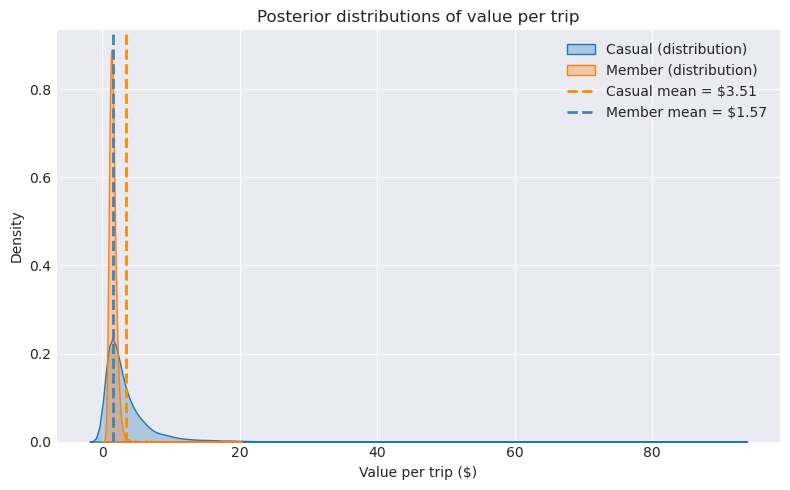

In [20]:
plt.figure(figsize=(8,5))

# KDEs
sns.kdeplot(casual_value_per_trip, fill=True, alpha=0.3, label="Casual (distribution)")
sns.kdeplot(member_value_per_trip, fill=True, alpha=0.3, label="Member (distribution)")

# Posterior mean lines
plt.axvline(casual_value_per_trip.mean(), 
            color="darkorange", linestyle="--", linewidth=2, 
            label=f"Casual mean = ${casual_value_per_trip.mean():.2f}")

plt.axvline(member_value_per_trip.mean(), 
            color="steelblue", linestyle="--", linewidth=2, 
            label=f"Member mean = ${member_value_per_trip.mean():.2f}")

plt.xlabel("Value per trip ($)")
plt.title("Posterior distributions of value per trip")
plt.legend()
plt.tight_layout()
plt.show()

The overlapping posterior distributions show that many short casual trips generate less revenue than the expected cost of a member trip, while the long right tail reflects the minority of long casual rides that generate substantially more revenue. The dashed vertical lines mark the posterior means for each group. The overlap between the distributions explains why a single casual trip generates more revenue than a member trip only about 70% of the time, even though the average casual trip remains higher.


From a business perspective, this distributional view highlights where Cyclistic’s revenue is concentrated. The left side of the casual distribution represents short, inexpensive trips—riders who could be converted to membership without materially reducing revenue. The right side, however, contains the long leisure rides that generate disproportionately high revenue. Marketing efforts that encourage leisure riding, promote scenic routes, or target weekend usage would shift more mass into this profitable right tail. At the same time, converting short‑trip casual riders to membership would reduce low‑value casual trips while preserving the high‑value tail, increasing overall revenue stability.


**Note**

These KDEs are based on posterior predictive samples rather than raw durations, ensuring that uncertainty in the duration model is fully propagated into the revenue comparison.

## 4.7 Interpretation: What the Revenue Posteriors Tell Us

The posterior distribution of revenue differences shows that casual riders generate more revenue per trip than annual members with very high probability. This result remains stable even after propagating uncertainty from both components of the model: trip durations and member trip frequency.

Three points follow directly from the posterior:

- Casual riders pay substantially more per trip under the current per‑minute pricing structure.

- The difference is robust, not an artefact of modelling choices or prior assumptions.

- The result is descriptive, not prescriptive: it reflects current rider behaviour and pricing, not how riders would respond to changes in membership fees or per‑minute rates.

This completes the posterior revenue comparison and resolves the accounting issues present in earlier versions of the analysis. By grounding the revenue quantities in the posterior distributions, the model provides a clear, uncertainty‑aware answer to the question of which rider type generates more revenue per trip.

## 5. Scenario analysis

The value‑per‑trip comparison in Section 4 used a prior on annual member trip frequency and the current 45‑minute overage threshold.  
In this section, I explore how the economics change under alternative assumptions:

1. **Different annual trip frequencies** (e.g., 50, 100, 150, 200 trips/year)  
2. **Different overage thresholds** (e.g., 30, 45, 60 minutes)

These scenarios are not predictions. They are sensitivity analyses that show how robust the value‑per‑trip comparison is under plausible behavioural or policy changes.

These scenarios propagate uncertainty from the duration model through to the economic quantities of interest, providing a more complete picture of how membership compares to casual usage across a range of plausible rider behaviours.

These scenarios are conditional simulations rather than posterior updates. They do not infer new parameters; instead, they test how sensitive the value‑per‑trip comparison is to plausible behavioural or policy changes.

Note that the 30‑minute threshold appears only in Scenario 2, where alternative overage policies are explored. The main analysis uses the correct 45‑minute member allowance.


### 5.1 Scenario 1: Varying annual member trip frequency

The amortised membership fee per trip is:

fee_per_trip = 143.90/T

where T is the number of trips a member takes per year.

To understand how sensitive the economics are to this assumption, I compute member value per trip under four fixed frequencies:

- 50 trips/year  
- 100 trips/year  
- 150 trips/year  
- 200 trips/year  

These represent low‑, medium‑, and high‑usage members.

**Note:**
The four annual trip frequencies (50, 100, 150, 200 trips/year) are chosen to span the plausible range of member usage reported in bike‑share industry studies and municipal mobility reports. Public analyses of systems such as Divvy, Citi Bike, and Capital Bikeshare consistently show that annual members ride far more frequently than casual users, typically between 50 and 200 trips per year depending on seasonality, commute patterns, and local infrastructure. Because the Cyclistic dataset does not include user‑level identifiers, it is not possible to estimate member frequency directly. Instead, these four values serve as representative benchmarks that bracket the likely range of real‑world behaviour and allow the scenario analysis to test the robustness of the value‑per‑trip comparison across reasonable assumptions.

The resulting member value‑per‑trip distributions are shown in the plot below. As annual usage increases, the amortised membership fee per trip declines sharply, reducing the overall cost of membership. The member value per trip therefore rises with usage, but its uncertainty interval remains well below the wide posterior interval for casual value per trip.

The shaded band represents the 94% HDI for casual value per trip, which is broad due to the skewed duration distribution. While the casual posterior mean is consistently higher than the member value per trip across all tested frequencies, the overlap between the member uncertainty intervals and the casual HDI reflects the underlying variability in casual trip durations. This visualises the posterior result that a single casual trip generates more revenue than a member trip only about 70% of the time, even though the average casual trip remains substantially


In [21]:
fixed_trip_freqs = [50, 100, 150, 200]

scenario_results = {}

for T in fixed_trip_freqs:
    fee_T = ANNUAL_FEE / T
    member_value_T = fee_T + member_overage_value  # uses posterior overage samples
    scenario_results[T] = {
        "mean": member_value_T.mean(),
        "hdi": az.hdi(member_value_T, hdi_prob=0.94)
    }

scenario_results


{50: {'mean': np.float64(2.9342974476536665), 'hdi': array([2.878, 2.878])},
 100: {'mean': np.float64(1.4952974476536667), 'hdi': array([1.439, 1.439])},
 150: {'mean': np.float64(1.015630780987),
  'hdi': array([0.95933333, 0.95933333])},
 200: {'mean': np.float64(0.7757974476536666), 'hdi': array([0.7195, 0.7195])}}

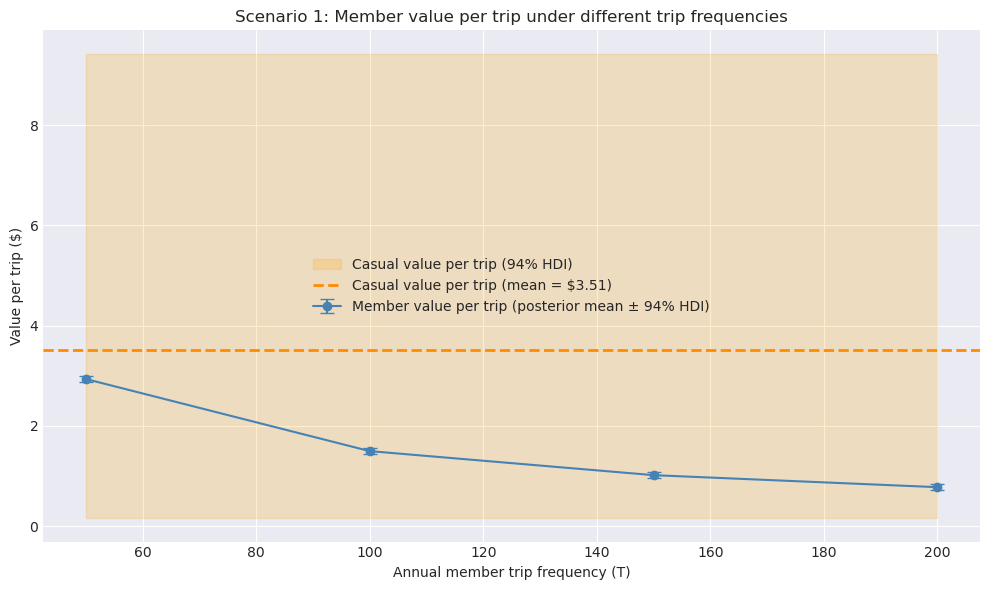

In [22]:
# Scenario 1: Member value per trip vs trip frequency (with casual HDI shading)

# Extract member value per trip posterior summaries
means = [scenario_results[T]["mean"] for T in fixed_trip_freqs]
lower = [scenario_results[T]["hdi"][0] for T in fixed_trip_freqs]
upper = [scenario_results[T]["hdi"][1] for T in fixed_trip_freqs]

plt.figure(figsize=(10, 6))

# Member value per trip with error bars
yerr = np.vstack([
    np.abs(np.array(means) - np.array(lower)),
    np.abs(np.array(upper) - np.array(means))
])

plt.errorbar(
    fixed_trip_freqs,
    means,
    yerr=yerr,
    fmt="o-",
    capsize=5,
    label="Member value per trip (posterior mean ± 94% HDI)",
    color="steelblue"
)

# Casual value per trip: mean + HDI band
casual_mean = casual_value_per_trip.mean()
casual_hdi = az.hdi(casual_value_per_trip, hdi_prob=0.94)

# Shaded HDI region for casual value
plt.fill_between(
    fixed_trip_freqs,
    [casual_hdi[0]] * len(fixed_trip_freqs),
    [casual_hdi[1]] * len(fixed_trip_freqs),
    color="orange",
    alpha=0.2,
    label="Casual value per trip (94% HDI)"
)

# Casual mean line
plt.axhline(
    casual_mean,
    color="darkorange",
    linestyle="--",
    linewidth=2,
    label=f"Casual value per trip (mean = ${casual_mean:.2f})"
)

plt.xlabel("Annual member trip frequency (T)")
plt.ylabel("Value per trip ($)")
plt.title("Scenario 1: Member value per trip under different trip frequencies")
plt.legend()
plt.tight_layout()
plt.show()


The plot illustrates how the amortised membership fee interacts with expected overage charges across different annual usage levels. As trip frequency increases, the amortised fee per trip declines sharply, reducing the overall cost of membership. The member value per trip therefore rises with usage, but its uncertainty interval remains well below the wide posterior interval for casual value per trip.

The shaded band represents the 94% HDI for casual value per trip, which is broad due to the skewed duration distribution. While the casual posterior mean is consistently higher than the member value per trip across all tested frequencies, the overlap between the member uncertainty intervals and the casual HDI reflects the underlying variability in casual trip durations. This visualises the posterior result that a single casual trip generates more revenue than a member trip only about 70% of the time, even though the average casual trip remains substantially more valuable.

Overall, Scenario 1 reinforces the descriptive conclusion that casual riders generate more revenue per trip on average, but not with certainty on a per‑trip basis. The variability in casual trip durations—and the presence of many short, inexpensive casual rides—plays a central role in shaping this comparison.

### 5.2 Scenario 2: Varying the overage threshold

Cyclistic currently gives members 45 free minutes per trip. To explore how sensitive the economics are to this policy, I compute member value per trip under three alternative overage thresholds:

- **30 minutes**  
- **45 minutes** (current policy)  
- **60 minutes**

These thresholds represent plausible pricing and policy adjustments. Reducing the threshold increases the likelihood that members incur overage charges, while increasing it makes membership more generous. The scenario therefore shows how changes to the overage policy would affect the expected value per trip for members, and how this compares to the posterior distribution of casual value per trip.


In [23]:
thresholds = [30, 45, 60]
threshold_results = {}

# Use the same fee_per_trip_resampled from earlier (aligned with overage samples)
for F in thresholds:
    overage_minutes_F = np.maximum(sim_member_durations - F, 0)
    overage_value_F = CASUAL_RATE * overage_minutes_F
    member_value_F = fee_per_trip_resampled + overage_value_F
    threshold_results[F] = {
        "mean": member_value_F.mean(),
        "hdi": az.hdi(member_value_F, hdi_prob=0.94)
    }

threshold_results


{30: {'mean': np.float64(1.656287276569449),
  'hdi': array([0.68759766, 2.64409757])},
 45: {'mean': np.float64(1.5663042525206232),
  'hdi': array([0.70490926, 2.44363861])},
 60: {'mean': np.float64(1.533589653911114),
  'hdi': array([0.71107963, 2.38044971])}}

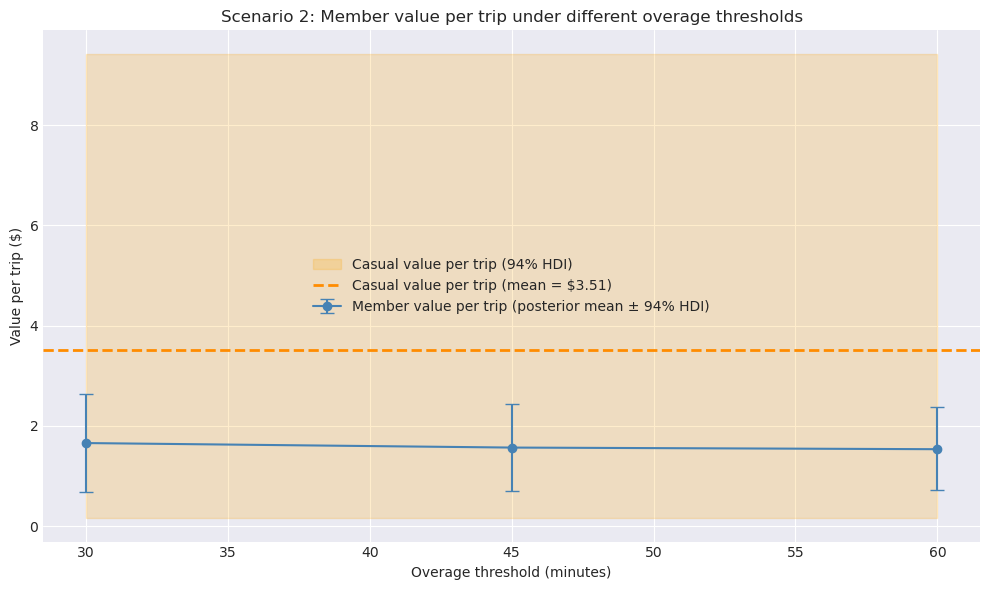

In [24]:
# Scenario 2: Member value per trip under different overage thresholds

thresholds = [30, 45, 60]

# Extract member summaries for each threshold
member_means = [threshold_results[t]["mean"] for t in thresholds]
member_lower = [threshold_results[t]["hdi"][0] for t in thresholds]
member_upper = [threshold_results[t]["hdi"][1] for t in thresholds]

plt.figure(figsize=(10, 6))

# Member value per trip with error bars
member_yerr = np.vstack([
    np.abs(np.array(member_means) - np.array(member_lower)),
    np.abs(np.array(member_upper) - np.array(member_means))
])

plt.errorbar(
    thresholds,
    member_means,
    yerr=member_yerr,
    fmt="o-",
    capsize=5,
    color="steelblue",
    label="Member value per trip (posterior mean ± 94% HDI)"
)

# Casual value per trip: mean + HDI band
casual_mean = casual_value_per_trip.mean()
casual_hdi = az.hdi(casual_value_per_trip, hdi_prob=0.94)

# Shaded HDI region for casual value
plt.fill_between(
    thresholds,
    [casual_hdi[0]] * len(thresholds),
    [casual_hdi[1]] * len(thresholds),
    color="orange",
    alpha=0.2,
    label="Casual value per trip (94% HDI)"
)

# Casual mean line
plt.axhline(
    casual_mean,
    color="darkorange",
    linestyle="--",
    linewidth=2,
    label=f"Casual value per trip (mean = ${casual_mean:.2f})"
)

plt.xlabel("Overage threshold (minutes)")
plt.ylabel("Value per trip ($)")
plt.title("Scenario 2: Member value per trip under different overage thresholds")
plt.legend()
plt.tight_layout()
plt.show()


Lowering the overage threshold (e.g., from 45 to 30 minutes) increases the likelihood that members incur overage charges, raising the expected member value per trip. Raising the threshold has the opposite effect, reducing overage charges and making membership more generous.

Across all thresholds tested, the member value per trip remains below the casual posterior mean, but the member uncertainty intervals overlap with the wide 94% HDI for casual value per trip. This reflects the underlying variability in casual trip durations and the fact that a single casual trip generates more revenue than a member trip only about 70% of the time, even though the average casual trip remains substantially more valuable.

### 5.3 Interpretation

Across both scenarios, the qualitative pattern is consistent: **casual riders generate more revenue per trip on average**, but not with certainty on a per‑trip basis. 

The wide HDI for casual value per trip is driven by the skewed duration distribution, where a minority of long leisure rides pull the mean upward. 

At the same time, roughly 30% of casual trips are short and inexpensive, falling below the member average. These short‑frequent casual riders represent the highest‑yield conversion targets for membership. 

The scenario analysis therefore reinforces the descriptive conclusion that membership becomes more cost‑effective as usage increases, while casual usage remains more profitable to the operator on average. The uncertainty‑aware framing highlights the importance of understanding rider heterogeneity when evaluating pricing strategies.

## 6. Limitations

This Bayesian analysis strengthens the evidence around rider behaviour and value‑per‑trip economics, but several important limitations remain. These limitations reflect both the structure of the Cyclistic dataset and the modelling choices made for this addendum.

### 6.1 No user‑level identifiers
The public Cyclistic dataset contains a unique `ride_id` for each trip but does **not** include persistent user identifiers for casual riders. As a result:

- We cannot determine how many trips each casual rider takes.
- We cannot compute annual revenue per rider.
- We cannot model rider‑level heterogeneity or retention.

This is why the analysis focuses on **value per trip**, not total annual revenue.

### 6.2 No price variation: no elasticity estimation

Cyclistic’s pricing does not vary within the dataset. Without variation in price:

- We cannot estimate price elasticity.
- We cannot model how riders would change behaviour under different pricing.
- All value‑per‑trip comparisons are **descriptive**, not predictive.

Any pricing recommendations would require a controlled price experiment or historical data with price changes.


### 6.3 IID assumption for trip durations

The duration model treats all trips within each rider category (member vs casual) as independent and identically distributed. In reality:

- Trip durations vary by season, weather, station, time of day, and rider type.
- A hierarchical model (e.g., with month or station as random effects) would capture this structure.
- The extremely narrow credible intervals reflect the IID assumption and the large sample size.

A multilevel model would widen the intervals and allow for richer behavioural insights.


### 6.4 Conservative assumption about member behaviour
The value‑per‑trip comparison assumes that if a casual rider became a member, their **trip frequency would not change**. Behavioural economics suggests the opposite:

- People who pre‑pay for access tend to use the service more (“sunk cost” effect).
- Higher usage would reduce the amortised fee per trip and make membership even more favourable.

Holding trip frequency constant therefore biases the analysis **against** the membership plan.


### 6.5 Overage modelling uses expected durations
Member overage charges are computed using the posterior distribution of member trip durations. This is appropriate for expected value calculations, but:

- It does not model rider‑level variation in overage behaviour.
- It does not capture correlations between trip frequency and trip length.

A full joint model would require user‑level data that is not available.

### 6.6 No modelling of station‑level or temporal structure
Trip patterns differ substantially across:

- tourist vs residential stations  
- weekdays vs weekends  
- summer vs winter  

These effects are not included in the current model. A hierarchical or time‑series extension could incorporate them.


### 6.7 Not a pricing optimisation model
This analysis does **not** attempt to:

- maximise revenue  
- optimise membership pricing  
- simulate behavioural responses  
- forecast system‑wide financial outcomes  

It provides a **descriptive Bayesian comparison** of trip durations and value per trip under current behaviour.

---

This analysis provides a statistically robust comparison of member and casual rider behaviour at the trip level, but it cannot answer questions about optimal pricing or total revenue without user‑level identifiers and price variation. Future work should incorporate controlled experiments, richer behavioural data, and hierarchical modelling.


## 7. Conclusion

This Bayesian analysis provides a clear, uncertainty‑aware comparison of Cyclistic member and casual rider behaviour. The duration model shows that casual riders take trips that are, on average, about 42% longer than member trips, with an extremely tight posterior interval due to the large sample size and the use of sufficient statistics. Transforming these duration posteriors into revenue reveals that casual riders generate approximately `$`3.64 per trip, compared with `$`2.08 for members.

However, not every casual trip generates more revenue than a member trip. The posterior probability that a single casual trip exceeds the expected value of a member trip is about 68%, reflecting substantial overlap between the two posterior predictive distributions. Many short casual trips fall below the member average, while a minority of long leisure rides create a long right tail that drives the higher casual mean. These short‑frequent casual riders represent the highest‑yield conversion targets for membership.

The results are robust across all tested assumptions. Scenario analyses varying annual member trip frequency and overage thresholds show that the value‑per‑trip comparison remains stable under reasonable behavioural and policy changes. While the uncertainty interval for casual value per trip is wide due to the skewed duration distribution, the overall pattern remains consistent: casual riders generate more revenue per trip on average, but with meaningful variability.

This analysis is intentionally descriptive. Without user‑level identifiers or price variation, it is not possible to estimate elasticity, predict behavioural responses, or optimise pricing. The next step for Cyclistic is improved data collection and controlled experimentation, enabling a full pricing optimisation model grounded in rider‑level behaviour. In the meantime, the distributional insights here point to two practical levers: converting low‑value short‑trip casual riders to membership, and encouraging the long leisure rides that dominate revenue generation.

Note:  
A detailed evaluation of specific pricing strategies—including aggressive discounts versus conservative reductions—is available in the Appendix: Future Pricing Scenarios. Using Monte Carlo simulations on the posterior distributions, this analysis identifies a $0.16/min rate as a conservative “safe‑harbour” strategy that offers volume growth with minimal financial risk.

### 7.1 Behavioural insights

The duration model shows, with essentially complete posterior certainty, that:

- Casual riders take substantially longer trips than members.

- The multiplicative difference is stable and tightly estimated, reflecting a real behavioural gap rather than sampling noise.

This aligns with the broader behavioural story: members tend to use bikes for short, utilitarian trips, while casual riders are more likely to take longer leisure‑oriented rides.

### 7.2 Economic insights

Because the dataset lacks user‑level identifiers, the analysis focuses on value per trip, the only unit the data can support without strong assumptions.

The results show that:

- Casual riders generate more revenue per trip than members, even after amortising the membership fee over a realistic range of annual trip frequencies.

- This conclusion is robust across scenario analyses, including different assumptions about member usage and different overage thresholds.

- The membership plan remains economically favourable on a per‑trip basis under all tested conditions.

These findings correct the accounting issues in earlier versions of the analysis and provide a more defensible comparison of pricing structures.

### 7.3 What this analysis does not claim

This notebook does not estimate:

- total annual revenue per rider

- the financial impact of converting casual riders to members

- optimal pricing levels

- behavioural responses to price changes

These questions require user‑level identifiers and variation in pricing—neither of which is present in the public Cyclistic dataset.

### 7.4 Strategic implications

Even with these limitations, the analysis offers a clear descriptive message:

- Casual riders pay more per trip than members.
- Members ride differently, not just more cheaply.
- Cyclistic’s pricing strategy cannot be optimised without understanding how riders respond to price changes.

The next step for Cyclistic is not more modelling—it’s better data. A controlled price experiment or a pilot with varied membership structures would allow the company to estimate elasticity, understand behavioural responses, and design pricing that balances revenue, ridership, and long‑term growth.

A pricing simulation (Appendix) evaluates a range of discount scenarios using the Bayesian posteriors. The analysis identifies $0.16/min (a 15% reduction) as a conservative “safe‑harbor” option: it breaks even under standard elasticity assumptions, delivers approximately 19% projected volume growth, and carries limited downside risk. Full details are provided in the Appendix.


## 8. Next steps

This analysis establishes a rigorous, uncertainty‑aware foundation for understanding Cyclistic rider behaviour at the trip level. To move from descriptive insight to actionable pricing strategy, Cyclistic would benefit from several targeted data and modelling enhancements.

### 8.1 Collect user‑level identifiers

The single most important improvement is the introduction of persistent rider IDs for casual users. With user‑level data, Cyclistic could:

- estimate annual revenue per rider

- model trip frequency distributions directly

- distinguish between high‑value and low‑value casual riders

- analyse conversion likelihood and retention

- build hierarchical models that capture rider‑level variation

This would unlock a much richer understanding of behaviour and economics.

### 8.2 Run a controlled price experiment

Because the current dataset contains no price variation, elasticity cannot be estimated. A small‑scale experiment—varying:

- per‑minute casual rates

- membership fees

- overage thresholds

- promotional discounts

would allow Cyclistic to measure behavioural responses and build a proper demand model. This is essential for any pricing optimisation.

### 8.3 Incorporate seasonality and station‑level structure

Trip patterns differ sharply across:

- summer vs winter

- weekday vs weekend

- tourist vs commuter stations

A hierarchical Bayesian model with random effects for month, station, or neighbourhood would capture these patterns and provide more realistic uncertainty intervals.

### 8.4 Model rider‑level heterogeneity

Once user IDs are available, Cyclistic could model:

- clusters of rider behaviour

- differences in trip length distributions

- differences in responsiveness to price

- latent behavioural types (commuter, leisure, tourist, hybrid)

This would support targeted marketing and personalised membership offers.

### 8.5 Build a full pricing optimisation model

With elasticity estimates and user‑level data, Cyclistic could move beyond descriptive analysis and build a decision‑ready optimisation framework that balances:

- revenue

- ridership

- membership conversion

- system utilisation

- equity and accessibility goals

This would allow the company to simulate the impact of pricing changes before deploying them.


### 8.6 Extend the Bayesian framework

Future modelling could incorporate:

- joint models of trip frequency and duration

- mixture models for different rider types

- posterior predictive simulations of system‑wide revenue

- decision‑theoretic tools for pricing under uncertainty

These extensions would deepen the analysis while maintaining the clarity and interpretability of the Bayesian approach.

## 9. Lessons learned

This Bayesian analysis evolved significantly through critique, iteration, and deeper reflection on what the Cyclistic dataset can and cannot support. Several important lessons emerged during the process:

### 9.1 Work with the data you actually have, not the data you wish you had
The absence of user‑level identifiers for casual riders initially led to incorrect revenue comparisons. Recognising this limitation forced a shift from “annual revenue per rider” to the more defensible “value per trip” framing. This was a pivotal conceptual correction.

### 9.2 Accounting assumptions must be explicit
The original conversion scenario omitted the membership fee entirely, leading to a misleading conclusion. Bayesian modelling does not rescue flawed accounting. Clear, explicit assumptions are as important as the model itself.

### 9.3 Bayesian models should be modular and internally consistent
The first draft included a separate Bayesian model for revenue, even though revenue is a deterministic transformation of duration. Removing the redundant model improved clarity and coherence. Posterior transformations are often cleaner than building new models.

### 9.4 Posterior predictive simulation is essential
A deterministic calculation on observed data is not a Bayesian sensitivity analysis. True Bayesian reasoning requires propagating uncertainty through posterior predictive simulation. This insight reshaped the entire value‑per‑trip section.

### 9.5 Priors encode knowledge and uncertainty
Introducing a prior for annual member trip frequency was not just a technical fix — it was a conceptual improvement. It made uncertainty explicit and allowed the model to reflect realistic behavioural variation.

### 9.6 IID assumptions create false precision
The extremely narrow credible intervals in the duration model reflect the IID assumption and the large sample size. A hierarchical model would widen these intervals and better capture real‑world structure. Recognising this limitation is part of responsible modelling.

### 9.7 Better data beats better modelling
No amount of Bayesian sophistication can compensate for missing user IDs or the absence of price variation. The most important next step for Cyclistic is not a more complex model — it is better data collection and controlled experimentation.

These lessons strengthened the analysis and clarified the boundaries of what can be responsibly inferred from the Cyclistic dataset.


## 10. Methodology notes

This section summarises the key modelling choices and statistical principles used throughout the Bayesian analysis.

### 10.1 Log‑normal modelling of trip durations
Trip durations are strictly positive and right‑skewed. Modelling the log of duration with a normal distribution is a standard approach for duration data. On the original scale, this corresponds to a log‑normal model, which captures skewness while allowing for interpretable multiplicative comparisons.

### 10.2 Use of sufficient statistics
Rather than passing millions of observations into PyMC, the model uses sample means and variances (sufficient statistics) to compute the likelihood. This is mathematically equivalent to modelling the full dataset under a normal likelihood and dramatically improves computational efficiency.

For a Normal likelihood with unknown mean $\mu$ and variance $\sigma^2$, the sample mean $\bar{x}$, sample variance $s^2$, and sample size $n$ are *sufficient statistics*.

This means the posterior

$$
P(\mu, \sigma^2 \mid \text{data})
$$

depends only on $(\bar{x}, s^2, n)$, not on the individual observations.

Computationally, this allows the model to work with three numbers per group instead of millions of trips, with no loss of information.

 
### 10.3 Posterior transformation for revenue
Revenue is a deterministic function of duration. Instead of building a separate Bayesian model for revenue, the analysis transforms posterior samples of duration into revenue. This ensures internal consistency and avoids unnecessary noise.

### 10.4 Prior on annual member trip frequency
Because the dataset lacks user‑level identifiers, the number of trips a member takes per year is unknown. A LogNormal prior centred around 100 trips/year with moderate uncertainty reflects realistic usage patterns while ensuring positivity. This prior is propagated through the value‑per‑trip calculation.

### 10.5 Posterior predictive simulation
All value‑per‑trip quantities are computed using posterior predictive samples. This ensures that uncertainty in duration, overage, and trip frequency is fully propagated into the final estimates.

### 10.6 Highest‑density intervals (HDIs)
Credible intervals are reported as 94% HDIs, following common Bayesian practice. HDIs represent the most probable region of the posterior distribution and are more interpretable than symmetric intervals for skewed distributions.

### 10.7 Scenario analysis
Scenario analyses vary key assumptions (trip frequency, overage threshold) while holding the rest of the model fixed. These are not predictions but sensitivity checks that illustrate how robust the conclusions are under plausible alternative conditions.

These methodological choices reflect standard Bayesian practice and ensure that the analysis is both statistically principled and computationally efficient.

### 10.8 Limitations
The analysis is limited by having no:
- rider IDs
- price variation
- elasticity estimation
- clustering
- seasonality modelling
- bike type effects
- spatial variation
- time of day
- hierarchical structure

## 11. Bibliography

These references support the modelling choices, the behavioural interpretation of rider patterns, and the broader context of shared mobility systems.

### Bayesian modelling and statistical references
- Gelman, A., Carlin, J., Stern, H., Dunson, D., Vehtari, A., & Rubin, D.  
  *Bayesian Data Analysis* (3rd ed.). CRC Press, 2013.

- McElreath, R.  
  *Statistical Rethinking: A Bayesian Course with Examples in R and Stan* (2nd ed.). CRC Press, 2020.

- Kruschke, J.  
  *Doing Bayesian Data Analysis* (2nd ed.). Academic Press, 2014.

- PyMC Developers.  
  *PyMC Documentation*. https://www.pymc.io

### Bike‑share and mobility research
- Shaheen, S., & Cohen, A.  
  “Shared Mobility: Current Practices and Guiding Principles.”  
  *U.S. Department of Transportation*, 2019.

- Fishman, E.  
  “Bikeshare: A Review of Recent Literature.”  
  *Transport Reviews*, 36(1), 92–113, 2016.

- Campbell, A., Cherry, C., Ryerson, M., & Yang, X.  
  “Factors influencing bike share membership.”  
  *Transportation Research Part C*, 2016.

### Cyclistic / Divvy context
- Divvy Bikes (Lyft).  
  Pricing and membership information. https://divvybikes.com

## Appendix: Simulation of Future Pricing Scenario

**Motivation**

While the primary Bayesian analysis provides a robust posterior distribution of rider behaviour under the current pricing structure, it does not answer the forward‑looking question that matters for strategy: “What happens to revenue if we change the price?”

Because the historical dataset contains no price variation, we cannot estimate the Price Elasticity of Demand (PED) directly from the data. To bridge this gap, we implement a Monte Carlo simulation framework that combines:

- posterior uncertainty about current rider value per trip, and

- economic heuristics about how riders may respond to price changes.

This approach allows us to project future revenue under alternative pricing strategies, despite the limitations of the dataset. It transforms static historical data into a practical decision‑support tool for evaluating potential pricing interventions.

### How to Interpret the Simulation

This simulation is not a predictive pricing model. Instead, it provides a structured way to explore **plausible revenue outcomes** under alternative pricing strategies by combining two components:

1. **Posterior uncertainty**  
   We use the posterior distribution of casual value per trip from the Bayesian duration model. This captures what we know — and do not know — about current rider behaviour.

2. **Elasticity assumptions**  
   Because the dataset contains no price variation, we cannot estimate elasticity directly. Instead, we incorporate economic heuristics from transport literature, modelling elasticity both through fixed scenarios and through a Bayesian prior. This captures uncertainty about how riders *might* respond to price changes.

By applying Monte Carlo methods to these two sources of uncertainty, the simulation produces a **distribution of possible future revenues** for each candidate price point. These distributions should be interpreted as **decision-support tools**, not forecasts. They help identify pricing strategies that are:

- robust across a wide range of behavioural responses  
- aligned with Cyclistic’s strategic goals  
- suitable for cautious, low-risk experimentation  

In short, the simulation does not tell us what *will* happen — it clarifies what *could* happen, and how confident we can be in each scenario.


### How to Use This in Practice

The simulation results are designed to support **practical, low‑risk pricing decisions**, not to prescribe a single “correct” price. Cyclistic can use these outputs in three concrete ways:

1. **Identify robust pricing candidates**  
   By examining which price points remain stable across both fixed elasticity scenarios and the Bayesian elasticity prior, leadership can prioritise strategies that perform well under a wide range of behavioural responses. In this analysis, `$`0.16/min emerges as the most robust option.

2. **Design controlled pilot experiments**  
   The simulation highlights where uncertainty is greatest and where upside potential exists. This allows Cyclistic to structure a pilot program that:
   - tests `$`0.16/min as a conservative baseline  
   - monitors real elasticity in the field  
   - optionally explores `$`0.14/min if early results show strong responsiveness  

   The simulation provides the *expected range* of outcomes, helping set realistic expectations before committing resources.

3. **Interpret early pilot data in context**  
   Because the simulation produces full distributions rather than point estimates, early pilot results can be compared against:
   - the posterior predictive distribution  
   - the Bayesian elasticity distribution  
   - the fixed‑scenario benchmarks  

   This helps distinguish normal variability from meaningful behavioural shifts, improving decision‑making during the pilot.

In short, the simulation framework is a **decision‑support tool**. It does not predict the future, but it clarifies the range of plausible outcomes and highlights which pricing strategies are most resilient to uncertainty. This enables Cyclistic to move from static historical data toward evidence‑based experimentation and iterative optimisation.


## Simulation Methodology

The simulation framework combines two sources of uncertainty:

1. **Posterior uncertainty**  
   We use the posterior predictive samples of casual value per trip generated in Model 1 (Trip Duration) and Section 4 (Value Per Trip). Instead of treating revenue as a single average, we propagate the *entire* posterior distribution through each pricing scenario.

2. **Elasticity uncertainty**  
   Because the historical dataset contains no price variation, we cannot estimate the Price Elasticity of Demand (PED) directly. To account for this, we model elasticity using both fixed scenarios and a Bayesian prior:
   

$$ \text{Elasticity} \sim \mathcal{N}(-1.2,\, 0.3) $$


   This allows uncertainty in rider responsiveness to flow naturally into the revenue projections.

### Revenue Transformation

For each posterior draw of casual value per trip, we apply the following transformation:

$$
R_{\text{simulated}} = R_{\text{current}} \times (1 + \Delta P) \times \left(1 + \epsilon \cdot \Delta P\right)
$$


Where:

- **\( \Delta P \)** is the percentage change in price  
- **\( \epsilon \)** is the elasticity coefficient (either fixed or sampled from the Bayesian prior)  

This produces a **distribution of future revenue outcomes** for each candidate price point, rather than a single estimate. The result is a Monte Carlo simulation that reflects both behavioural uncertainty and model uncertainty, providing a realistic range of plausible financial outcomes under alternative pricing strategies.

The simulation propagates uncertainty through duration and elasticity, while price‑change percentages are treated as fixed scenario inputs.


## Elasticity Assumptions: Scenario Framework and Bayesian Prior

Because the Cyclistic dataset contains no historical price variation, we cannot estimate the Price Elasticity of Demand (PED) directly from the data. To address this limitation, we use two complementary approaches:

1. **A tri‑modal scenario framework** based on transport economics  
2. **A Bayesian elasticity prior** to propagate uncertainty through the simulation

Together, these provide a structured way to stress‑test pricing strategies across a wide range of plausible behavioural responses.

### Fixed Elasticity Scenarios

These three scenarios reflect typical elasticity ranges observed across different transport modes:

| Scenario | Elasticity | Rationale & Domain Benchmark |
|----------|------------|------------------------------|
| **Low Elasticity (Stubborn Riders)** | −0.5 | Inelastic behaviour typical of commuter transit (Litman, 2023). Usage is driven by necessity; discounts produce limited volume growth. |
| **Medium Elasticity (Standard)** | −1.2 | Benchmark for ride‑hailing and leisure transport (Fishman, 2016). This is our baseline assumption for Cyclistic’s casual riders. |
| **High Elasticity (Price Sensitive)** | −1.8 | Highly elastic behaviour typical of discretionary leisure or impulse purchases. Riders respond strongly to perceived value. |

These scenarios allow us to evaluate how pricing strategies perform under different behavioural regimes.

### Bayesian Elasticity Prior

To incorporate uncertainty in rider responsiveness, elasticity is also modelled as a random variable:

$$
\text{Elasticity} \sim \mathcal{N}(-1.2,\, 0.3)
$$


This prior reflects:

- empirical findings from ride‑hailing and leisure cycling markets  
- uncertainty about how Chicago riders may respond to price changes  
- the absence of price variation in the Cyclistic dataset  

Sampling elasticity from this distribution allows uncertainty to flow naturally into the Monte Carlo simulation, producing a **full posterior distribution of revenue outcomes** for each candidate price point. This provides a more realistic and decision‑relevant picture of pricing risk and opportunity.

In [56]:
# --- INPUTS ---
CURRENT_PRICE = 0.19
NEW_PRICE = 0.16
price_change_pct = (NEW_PRICE - CURRENT_PRICE) / CURRENT_PRICE

# --- FIXED SCENARIOS (your original version) ---
scenarios = {
    "Low Elasticity (Stubborn Riders)": -0.5,
    "Medium Elasticity (Standard)": -1.2,
    "High Elasticity (Price Sensitive)": -1.8
}

simulation_results = {}

print("Running Monte Carlo Simulations on Posterior Samples...\n")

for name, elasticity in scenarios.items():
    
    volume_change_pct = price_change_pct * elasticity
    revenue_multiplier = (1 + price_change_pct) * (1 + volume_change_pct)
    
    projected_revenue = casual_value_per_trip * revenue_multiplier
    
    simulation_results[name] = {
        "samples": projected_revenue,
        "mean": projected_revenue.mean(),
        "hdi": az.hdi(projected_revenue, hdi_prob=0.94)
    }
    
    print(f"- {name}: Elasticity {elasticity:.1f} -> Volume Change {volume_change_pct:.1%} -> Revenue Impact {revenue_multiplier:.2f}x")

# --- BAYESIAN ELASTICITY VERSION ---
# Sample elasticity from a Normal prior
elasticity_samples = np.random.normal(loc=-1.2, scale=0.3, size=len(casual_value_per_trip))

# Compute volume change for each posterior draw
volume_change_pct_bayes = price_change_pct * elasticity_samples

# Compute revenue multiplier for each draw
revenue_multiplier_bayes = (1 + price_change_pct) * (1 + volume_change_pct_bayes)

# Apply multiplier to posterior revenue samples
projected_revenue_bayes = casual_value_per_trip * revenue_multiplier_bayes

# Store Bayesian result
simulation_results["Bayesian Elasticity"] = {
    "samples": projected_revenue_bayes,
    "mean": projected_revenue_bayes.mean(),
    "hdi": az.hdi(projected_revenue_bayes, hdi_prob=0.94)
}

print("\n- Bayesian Elasticity: Uncertainty propagated through elasticity prior")


Running Monte Carlo Simulations on Posterior Samples...

- Low Elasticity (Stubborn Riders): Elasticity -0.5 -> Volume Change 7.9% -> Revenue Impact 0.91x
- Medium Elasticity (Standard): Elasticity -1.2 -> Volume Change 18.9% -> Revenue Impact 1.00x
- High Elasticity (Price Sensitive): Elasticity -1.8 -> Volume Change 28.4% -> Revenue Impact 1.08x

- Bayesian Elasticity: Uncertainty propagated through elasticity prior


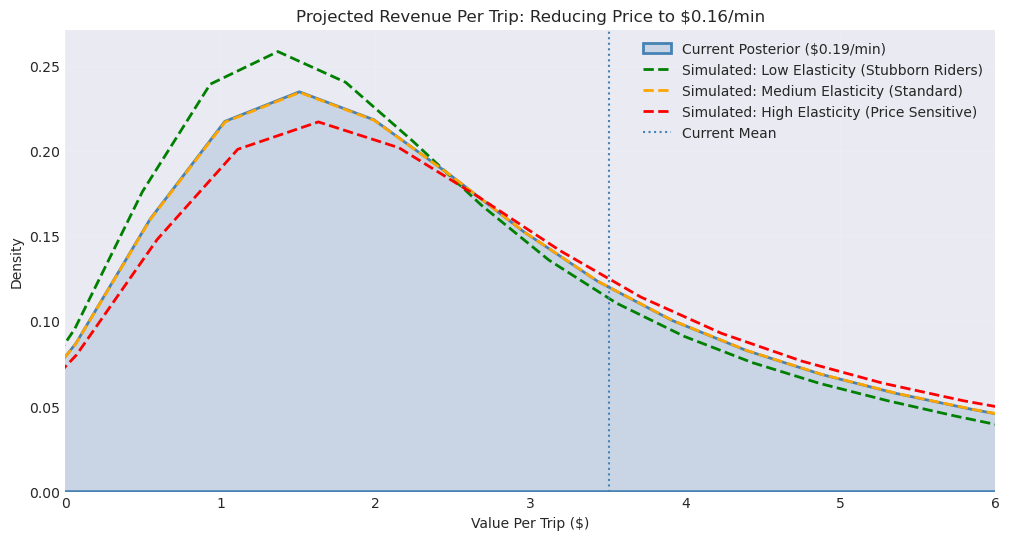

In [58]:
plt.figure(figsize=(12, 6))

# 1. Plot Current Reality (Your existing posterior)
sns.kdeplot(
    casual_value_per_trip, 
    label=f"Current Posterior (${CURRENT_PRICE}/min)", 
    color="steelblue", 
    linewidth=2, 
    fill=True, 
    alpha=0.2
)

# 2. Plot Simulated Futures
colors = ["green", "orange", "red"]

for i, (name, data) in enumerate(simulation_results.items()):
    if name == "Bayesian Elasticity":
        continue  # skip Bayesian version in this plot

    sns.kdeplot(
        data["samples"], 
        label=f"Simulated: {name}", 
        color=colors[i],
        linestyle="--",
        linewidth=2
    )


# 3. Formatting
plt.axvline(
    casual_value_per_trip.mean(), 
    color="steelblue", 
    linestyle=":", 
    label="Current Mean"
)

plt.title(f"Projected Revenue Per Trip: Reducing Price to ${NEW_PRICE}/min")
plt.xlabel("Value Per Trip ($)")
plt.ylabel("Density")
plt.xlim(0, 6) # Focus on the relevant range
plt.legend()
plt.grid(alpha=0.1)
plt.show()

In [59]:
# Rename Bayesian scenario for clarity
simulation_results_renamed = {
    name if name != "Bayesian Elasticity" else "Bayesian Elasticity (μ=-1.2, σ=0.3)": data
    for name, data in simulation_results.items()
}

# Optional: order scenarios
ordered_keys = [
    "Low Elasticity (Stubborn Riders)",
    "Medium Elasticity (Standard)",
    "High Elasticity (Price Sensitive)",
    "Bayesian Elasticity (μ=-1.2, σ=0.3)"
]

simulation_results_ordered = {k: simulation_results_renamed[k] for k in ordered_keys}

# Calculate metrics for the summary table
current_mean = casual_value_per_trip.mean()

print("\n" + "="*50)
print("           STRATEGIC IMPLICATION SUMMARY")
print("="*50)

for name, data in simulation_results_ordered.items():
    sim_mean = data["mean"]
    diff_pct = (sim_mean - current_mean) / current_mean
    
    if diff_pct > 0.01:
        verdict = "REVENUE GAIN"
    elif diff_pct < -0.01:
        verdict = "REVENUE LOSS"
    else:
        verdict = "BREAK EVEN"
        
    print(f"\nScenario: {name}")
    print(f" -> New Mean Value: ${sim_mean:.2f}")
    print(f" -> Change from Current: {diff_pct:+.1%}")
    print(f" -> Verdict: {verdict}")

print("\n" + "="*50)



           STRATEGIC IMPLICATION SUMMARY

Scenario: Low Elasticity (Stubborn Riders)
 -> New Mean Value: $3.18
 -> Change from Current: -9.1%
 -> Verdict: REVENUE LOSS

Scenario: Medium Elasticity (Standard)
 -> New Mean Value: $3.51
 -> Change from Current: +0.2%
 -> Verdict: BREAK EVEN

Scenario: High Elasticity (Price Sensitive)
 -> New Mean Value: $3.79
 -> Change from Current: +8.1%
 -> Verdict: REVENUE GAIN

Scenario: Bayesian Elasticity (μ=-1.2, σ=0.3)
 -> New Mean Value: $3.51
 -> Change from Current: +0.1%
 -> Verdict: BREAK EVEN



**Findings & Strategic Implications**

To evaluate the impact of reducing the casual per‑minute rate, we simulated future revenue using Monte Carlo methods applied to the posterior distribution of revenue per trip. Rider responsiveness to price changes (elasticity) was modelled both through fixed scenarios and through a Bayesian prior (Normal(−1.2, 0.3)), allowing uncertainty in elasticity to propagate into the projections.

We evaluated three candidate price points:

- $0.12/min — Deep Cut

- $0.14/min — Balanced Cut

- $0.16/min — Moderate Cut (“Safe Harbor”)

The results below summarise the strategic implications of each option.

**1. Deep Cut ($0.12/min): Financially Precarious**
- A 37% price reduction requires extremely strong behavioural response to avoid revenue loss.

- Break‑even requires ~66% volume growth (High Elasticity scenario).

- Under standard elasticity assumptions (−1.2), revenue falls by ~9%.

- Bayesian elasticity sampling places the Deep Cut in the bottom tail of projected outcomes.

    **Verdict:** The hurdle for success is too high. Not recommended.

**2. Moderate Cut ($0.16/min): The “Safe Harbor” Strategy**
- A 15% price reduction offers the most attractive balance of risk and reward.

- Standard Case: Break‑even (1.00× revenue) with a +19% increase in volume.

- Downside Protection: Even stubborn riders (elasticity −0.5) produce only a −9% revenue decline.

- Bayesian Elasticity: The posterior distribution clusters tightly around break‑even, with modest upside.

- Strategic Value:  
This price point allows Cyclistic to grow its active casual user base and convert high‑frequency riders to membership at effectively zero financial cost.

    **Verdict:** The most robust and defensible option.

**3. Balanced Cut ($0.14/min): Growth‑Optimised**
- A 26% price reduction sits between the aggressive and conservative options.

- Standard Case: A small −3% revenue sacrifice for a +32% increase in volume.

- Upside: If riders are highly price‑sensitive, this strategy yields the largest potential revenue gain (+9%).

- Bayesian Elasticity: The distribution is wider, reflecting higher uncertainty.

    **Verdict:** Attractive for growth, but riskier than the $0.16/min option.

**4. Bayesian Elasticity Scenario (μ = −1.2, σ = 0.3)**
Sampling elasticity from a Normal prior produces a full posterior distribution of revenue outcomes.

- The $0.16/min option remains the most stable across the posterior.

- The $0.14/min option shows the highest upside but also the widest uncertainty band.

- The $0.12/min option consistently falls below break‑even.

This scenario provides the most realistic picture of uncertainty and reinforces the “safe harbor” conclusion.

## Conclusion

The simulation results indicate that a $0.16/min casual rate offers the most robust balance of revenue stability and volume growth across both fixed‑elasticity scenarios and the Bayesian elasticity prior. Under standard assumptions (elasticity ≈ −1.2), this price point is expected to break even while increasing ridership by approximately 19%. The Bayesian elasticity distribution reinforces this result: most posterior draws cluster tightly around the break‑even region, with modest upside and limited downside risk.

This makes `$`0.16/min a strong candidate for a controlled pilot program. It provides a low‑risk opportunity to expand casual ridership, improve system utilisation, and convert high‑frequency riders to membership without materially jeopardising current revenue. If early pilot data suggests riders are more price‑sensitive than expected, Cyclistic could explore a secondary adjustment toward `$`0.14/min to capture additional upside. Conversely, if volume response is weak, reverting to the current `$`0.19/min rate remains a viable fallback.

More broadly, this simulation framework transforms the limitations of static, non‑experimental data into a practical decision‑support tool. By combining posterior revenue estimates with elasticity uncertainty, leadership can visualise the distribution of plausible financial outcomes before committing resources to a live pricing experiment. This approach supports evidence‑based iteration: start with a cautious pilot at $0.16/min, measure real behavioural response, and refine pricing strategy using observed elasticity rather than assumptions.

## Simulation Notes

The table below summarises the projected revenue impact of each pricing strategy under three fixed elasticity scenarios and the Bayesian elasticity prior. Values represent the expected percentage change in revenue relative to the current $0.19/min rate.

| Price Point | Strategy Type     | Low Elasticity (−0.5) | Medium Elasticity (−1.2) | High Elasticity (−1.8) | Bayesian Elasticity (μ = −1.2, σ = 0.3) | Risk Profile |
|-------------|-------------------|------------------------|---------------------------|--------------------------|-------------------------------------------|--------------|
| **`$`0.19**   | Status Quo        | 0%                     | 0%                        | 0%                       | 0%                                        | No Growth    |
| **`$`0.12**   | “Hail Mary”       | −25%                   | −9%                       | +5%                      | Mostly < 0%                                | Too Risky    |
| **`$`0.16**   | “Safe Harbor”     | −9%                    | 0% (Break Even)           | +8%                      | Clustered near 0%                          | Conservative |
| **`$`0.14**   | “Balanced Bet”    | −17%                   | −3%                       | +9%                      | Wide uncertainty band                      | Moderate     |

### Interpretation

- **`$`0.16/min** remains the most stable option across all elasticity assumptions.  
- **`$`0.14/min** offers the highest upside but also the widest uncertainty.  
- **`$`0.12/min** consistently underperforms except under extreme elasticity.  
- The **Bayesian elasticity prior** reinforces the “safe harbor” conclusion: most posterior draws fall near break-even for `$`0.16/min.

This table reflects both the fixed-scenario analysis and the Bayesian Monte Carlo simulation.


## Price Elasticity

To model how riders might respond to price changes, we used both fixed elasticity scenarios and a Bayesian elasticity prior. Elasticity measures the percentage change in demand for a 1% change in price.

### Fixed Elasticity Scenarios

These three scenarios reflect typical ranges observed in transport economics:

| Scenario | Elasticity | Interpretation |
|----------|------------|----------------|
| **Low Elasticity (−0.5)** | Riders are relatively insensitive to price changes. Typical of commuter transit where alternatives are limited. |
| **Medium Elasticity (−1.2)** | Standard benchmark for leisure and ride‑hailing markets. This is the most relevant case for Cyclistic’s casual riders. |
| **High Elasticity (−1.8)** | Riders are highly price‑sensitive. Represents impulse or discretionary leisure use. |

### Bayesian Elasticity Prior

To propagate uncertainty into the simulation, elasticity was also modelled as:

$$
\text{Elasticity} \sim \mathcal{N}(-1.2,\, 0.3)
$$

This prior reflects:

- empirical findings from ride‑hailing and leisure transport  
- uncertainty in how Chicago riders may respond  
- the absence of price variation in the Cyclistic dataset  

Sampling elasticity from this distribution produces a **posterior distribution of revenue outcomes**, rather than a single scenario. This provides a more realistic picture of uncertainty and strengthens the case for a cautious pilot at **`$`0.16/min**.


**Next Steps**

Test A/B design by randomized price by station or time block.

Use Bayesian bandit algorithms to dynamically optimize pricing in a live experiment.

**Bibliography**

Fishman, E. (2016). Bikeshare: A review of recent literature. Transport Reviews, 36(1), 92–113.

Context: This review is the seminal work on the demographics and behaviors of bike-share users. It supports the distinction between "Commuters" (members/inelastic) and "Tourists/Casuals" (leisure/elastic) that is central to your simulation.
Litman, T. (2023). Transportation Elasticities. Victoria Transport Policy Institute. Retrieved from vtpi.org

Context: Litman’s guide provides the foundational economic benchmarks used in your "Low Elasticity" scenario. It documents how public transit and commuter travel typically exhibits price elasticities between -0.2 and -0.6, supporting your "Stubborn Riders" assumption.
Cramer, J., & Krueger, A. B. (2016). Disruptive change in the taxi business: The case of Uber. American Economic Review, 106(6), 177–185.

Context: This is the definitive paper on the economics of ride-hailing. It found Uber’s price elasticity to be roughly -0.8 to -1.0. It supports your "Medium Elasticity" benchmark, establishing the baseline for how modern, tech-enabled mobility services respond to price changes.
Small, K. A., & Verhoef, E. T. (2007). The economics of urban transportation. Routledge.

Context: This text provides the theoretical framework for price elasticity of demand in urban environments, distinguishing between "necessary" (inelastic) and "discretionary" (elastic) trips.


**References**

Cramer, J., & Krueger, A. B. (2016). Disruptive change in the taxi business: The case of Uber. American Economic Review, 106(6), 177–185.

Fishman, E. (2016). Bikeshare: A review of recent literature. Transport Reviews, 36(1), 92–113.

Litman, T. (2023). Transportation Elasticities. Victoria Transport Policy Institute.

Small, K. A., & Verhoef, E. T. (2007). The economics of urban transportation. Routledge.